## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [31]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import timm

We always check that we are running on a GPU

In [32]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [33]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./hotdog_nothotdog/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [34]:
size = 128
#train_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor()])
#test_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor()])

#""" #optional data augmentation
train_transform = transforms.Compose([
    #transforms.Resize((size, size)),
    transforms.RandomResizedCrop(size, scale=(0.7, 1.0)), #added
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5), #added
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#"""


batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [35]:
print(len(train_loader), len(test_loader))


32 30


Now create a model and train it!


In [36]:
#2047 pics of hotdogs & not hotdogs in train set
#1862 pics of hotdog & not hotdogs in test set
#-> balanced sets, no weight for sampler

#EfficientNet B0 model
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=1)
model = model.to(torch.device("cuda"))

#optimizer (might change)
#optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4) #maybe more
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

#loss function (might change -> nn.LogSoftmax or nn.CrossEntropyLoss or ?)
#loss_fn = nn.BCEWithLogitsLoss()
#scheduler for adaptive learning rate, if the gradient is stuck
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.2)
epochs = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, 
    steps_per_epoch=len(train_loader), 
    epochs=epochs
)



In [37]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        return (self.alpha * (1-pt)**self.gamma * bce_loss).mean()

loss_fn = FocalLoss()

In [38]:
#logs accuracy&loss
output_dict = {'training_loss': [], 'test_loss': [], 'accuracy': [], 'f1': []}

#training loop
device = torch.device("cuda")

for epoch in tqdm(range(epochs), unit='epoch'):
    model.train()
    train_loss = 0.0

    for _, (data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #to device
        data = data.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        #zero gradient
        optimizer.zero_grad()
        #forward pass
        outputs = model(data)
        #compute loss
        loss = loss_fn(outputs, labels)
        #backward pass
        loss.backward()
        #update weights
        optimizer.step()
        scheduler.step()

        #add loss to plot
        train_loss += loss.item()

    avg_training_loss = train_loss / len(train_loader)

    #model validation / test accuracy
    model.eval()
    test_loss = 0.0
    predicted_val = []
    true_val = []

    #same with test set
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(data)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()

            #squeeze btw 0 and 1
            probs = torch.sigmoid(outputs).cpu().numpy()
            #add to list if predicted ie. if probs > 0.5
            predicted_val.extend((probs > 0.5).astype(int))
            true_val.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(true_val, predicted_val)
    f1 = f1_score(true_val, predicted_val)

    output_dict['training_loss'].append(avg_training_loss)
    output_dict['test_loss'].append(avg_test_loss)
    output_dict['accuracy'].append(accuracy)
    output_dict['f1'].append(f1)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_training_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Acc: {accuracy:.4f} | F1: {f1:.4f}")
    #upudating learning rate
    scheduler.step(avg_test_loss)

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.8951 | Test Loss: 1.3278 | Acc: 0.7089 | F1: 0.7073


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.1355 | Test Loss: 1.0956 | Acc: 0.7615 | F1: 0.7760


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8505 | Test Loss: 0.9250 | Acc: 0.7798 | F1: 0.7917


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.7934 | Test Loss: 0.8462 | Acc: 0.7986 | F1: 0.8042


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.6139 | Test Loss: 0.7756 | Acc: 0.8045 | F1: 0.8141


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5949 | Test Loss: 0.7174 | Acc: 0.8217 | F1: 0.8276


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.5425 | Test Loss: 0.6709 | Acc: 0.8233 | F1: 0.8324


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4903 | Test Loss: 0.6312 | Acc: 0.8249 | F1: 0.8332


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.4815 | Test Loss: 0.6249 | Acc: 0.8298 | F1: 0.8383


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.3709 | Test Loss: 0.5884 | Acc: 0.8367 | F1: 0.8462


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.3898 | Test Loss: 0.5887 | Acc: 0.8367 | F1: 0.8431


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.3182 | Test Loss: 0.5691 | Acc: 0.8346 | F1: 0.8454


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2868 | Test Loss: 0.5448 | Acc: 0.8448 | F1: 0.8514


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.3213 | Test Loss: 0.5030 | Acc: 0.8459 | F1: 0.8514


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.2962 | Test Loss: 0.4852 | Acc: 0.8491 | F1: 0.8549


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.2362 | Test Loss: 0.4521 | Acc: 0.8620 | F1: 0.8668


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.2657 | Test Loss: 0.4504 | Acc: 0.8614 | F1: 0.8673


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2374 | Test Loss: 0.4306 | Acc: 0.8625 | F1: 0.8693


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2226 | Test Loss: 0.4239 | Acc: 0.8604 | F1: 0.8679


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.2079 | Test Loss: 0.4187 | Acc: 0.8647 | F1: 0.8641


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1671 | Test Loss: 0.4031 | Acc: 0.8641 | F1: 0.8701


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1622 | Test Loss: 0.4023 | Acc: 0.8673 | F1: 0.8722


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1434 | Test Loss: 0.3743 | Acc: 0.8684 | F1: 0.8743


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1634 | Test Loss: 0.3904 | Acc: 0.8727 | F1: 0.8756


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1425 | Test Loss: 0.3629 | Acc: 0.8781 | F1: 0.8806


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1002 | Test Loss: 0.3487 | Acc: 0.8759 | F1: 0.8816


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1294 | Test Loss: 0.3364 | Acc: 0.8765 | F1: 0.8793


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1378 | Test Loss: 0.3312 | Acc: 0.8706 | F1: 0.8770


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1130 | Test Loss: 0.3221 | Acc: 0.8765 | F1: 0.8817


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1314 | Test Loss: 0.3509 | Acc: 0.8797 | F1: 0.8835


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0852 | Test Loss: 0.3218 | Acc: 0.8727 | F1: 0.8788


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0866 | Test Loss: 0.3735 | Acc: 0.8759 | F1: 0.8810


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0863 | Test Loss: 0.3279 | Acc: 0.8754 | F1: 0.8814


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0773 | Test Loss: 0.3376 | Acc: 0.8759 | F1: 0.8804


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0781 | Test Loss: 0.3210 | Acc: 0.8792 | F1: 0.8843


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1005 | Test Loss: 0.3048 | Acc: 0.8818 | F1: 0.8843


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0752 | Test Loss: 0.3023 | Acc: 0.8786 | F1: 0.8834


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0711 | Test Loss: 0.2914 | Acc: 0.8818 | F1: 0.8872


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0766 | Test Loss: 0.2882 | Acc: 0.8835 | F1: 0.8872


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0577 | Test Loss: 0.2696 | Acc: 0.8792 | F1: 0.8841


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0580 | Test Loss: 0.2730 | Acc: 0.8818 | F1: 0.8867


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0594 | Test Loss: 0.2685 | Acc: 0.8856 | F1: 0.8901


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0662 | Test Loss: 0.2650 | Acc: 0.8808 | F1: 0.8862


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0536 | Test Loss: 0.2607 | Acc: 0.8910 | F1: 0.8923


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0580 | Test Loss: 0.2520 | Acc: 0.8813 | F1: 0.8871


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0537 | Test Loss: 0.2559 | Acc: 0.8792 | F1: 0.8868


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0601 | Test Loss: 0.2368 | Acc: 0.8845 | F1: 0.8898


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0439 | Test Loss: 0.2422 | Acc: 0.8894 | F1: 0.8938


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0546 | Test Loss: 0.2417 | Acc: 0.8883 | F1: 0.8933


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0445 | Test Loss: 0.2314 | Acc: 0.8861 | F1: 0.8925


C:\Users\Elio\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


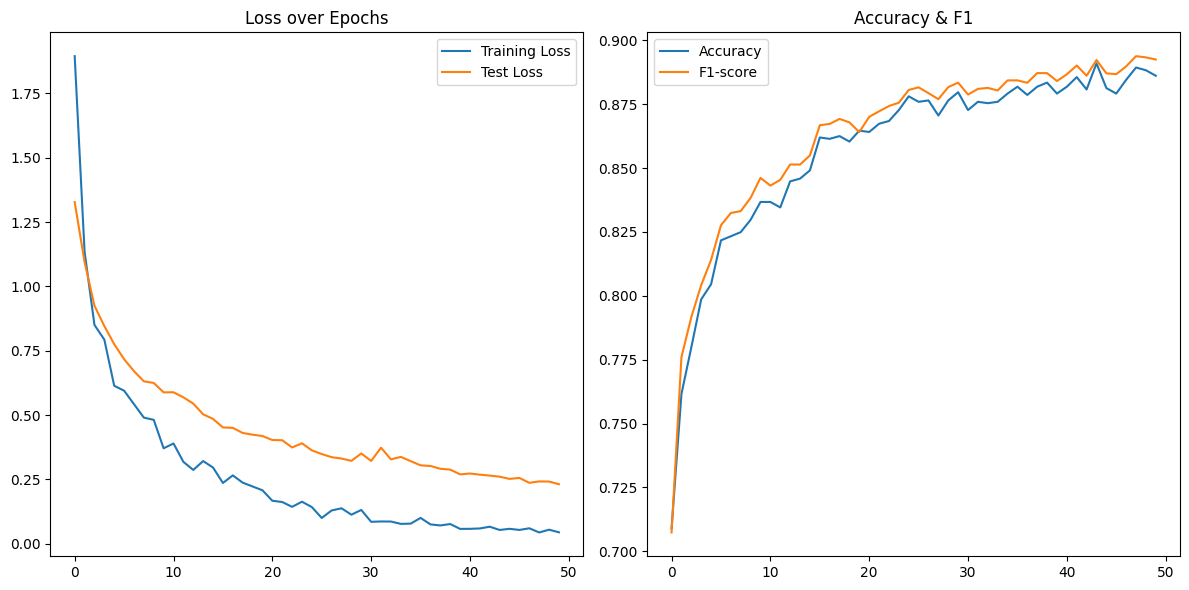

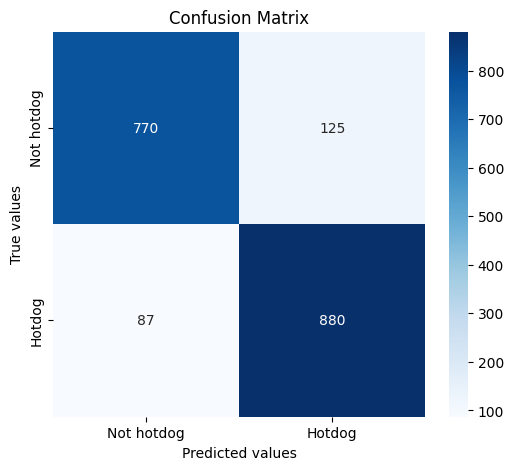

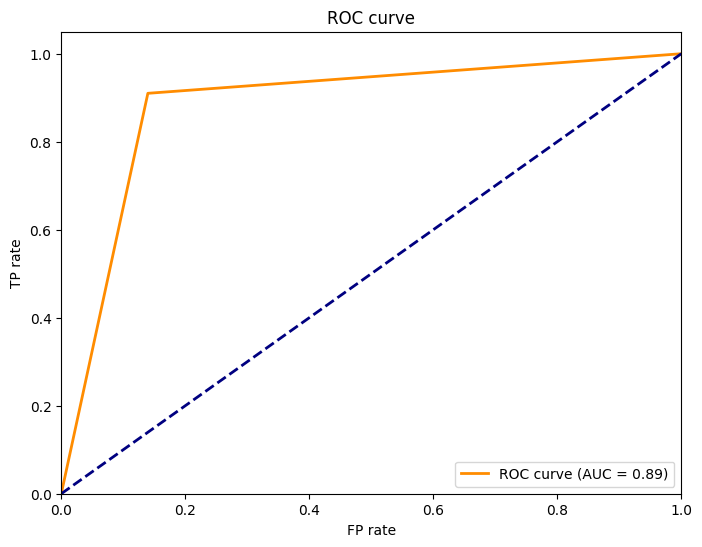

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#metrics and plots
def plot_metrics(output_dict, true, preds):

    #losses and accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(output_dict['training_loss'], label='Training Loss')
    plt.plot(output_dict['test_loss'], label='Test Loss')
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)

    plt.plot(output_dict['accuracy'], label='Accuracy')
    plt.plot(output_dict['f1'], label='F1-score')
    plt.legend()
    plt.title("Accuracy & F1")
    plt.tight_layout()

    plt.show()

    #confusion matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Not hotdog", "Hotdog"], yticklabels=["Not hotdog", "Hotdog"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted values")
    plt.ylabel("True values")

    plt.show()

    #ROC curve & AUC
    fpr, tpr, _ = roc_curve(true, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


model.eval()
preds = []
true = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds.extend((probs > 0.5).astype(int))
        true.extend(labels.cpu().numpy())

#call
plot_metrics(output_dict, true_val, predicted_val)
